In [1]:
import tensorly as tl
tl.set_backend('tensorflow')
import tensorflow as tf
tfe = tf.contrib.eager

import numpy as np
import t3f
tf.set_random_seed(0)
np.random.seed(0)
%matplotlib inline
import matplotlib.pyplot as plt
from nilearn import image
from tensorflow.python.util import nest
import copy
from nilearn import plotting
from scipy import optimize 
from nilearn.masking import compute_background_mask
from nilearn.masking import compute_epi_mask
from collections import OrderedDict
import pandas as pd
from scipy import stats
from nilearn.image import math_img
import nibabel as nib
import tensorly as tl
from tensorly.decomposition import tucker
from tensorly.tucker_tensor import tucker_to_tensor
from tensorflow.python.eager.context import context, EAGER_MODE, GRAPH_MODE
from tensorly.random import check_random_state
import tensorly.backend as T
import tensor_util as tu
import mri_draw_utils as mrd
import os

Using numpy backend.
Using tensorflow backend.
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/ec2-user/.local/lib/python3.6/site-packages/nilearn/plotting/__init__.py:20: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/r

In [2]:
def switch_to(mode):
    ctx = context()._eager_context
    ctx.mode = mode
    ctx.is_eager = mode == EAGER_MODE

In [3]:
def get_mask(data, observed_ratio):
    
    if len(data.shape) == 3:
        mask_indices = (np.random.rand(data.shape[0],data.shape[1],data.shape[2]) < observed_ratio).astype('int') 
    elif len(data.shape) == 4:
        mask_indices = (np.random.rand(data.shape[0],data.shape[1],data.shape[2], data.shape[3]) < observed_ratio).astype('int') 
    elif len(data.shape) == 2:
        mask_indices = (np.random.rand(data.shape[0],data.shape[1]) < observed_ratio).astype('int') 
    return mask_indices


def read_image_abs_path(path):
    img = nib.load(path)
    return img

def reconstruct_image_affine(img_ref, x_hat):
    result = nib.Nifti1Image(x_hat, img_ref.affine)
    return result

def reconstruct(x_hat,x_true, ten_ones, mask):
    x_reconstruct = np.multiply(mask,x_true) + np.multiply((ten_ones - mask), x_hat)
    return x_reconstruct

def tsc(x_hat,x_true, ten_ones, mask):
    nomin = np.linalg.norm(np.multiply((ten_ones - mask), (x_true - x_hat)))
    denom = np.linalg.norm(np.multiply((ten_ones - mask), x_true))
    score = nomin/denom
    return score

def frobenius_norm_tf_squared(x):
    return tf.reduce_sum(x ** 2)

def frobenius_norm_tf(x):
    return tf.reduce_sum(x ** 2) ** 0.5

def tsc_tf(x_rec, x_true, tf_ones,sparsity_mask,sparse_observation):
    nomin = frobenius_norm_tf((tf_ones - sparsity_mask)*(x_rec - sparse_observation))
    denom = frobenius_norm_tf((ten_ones - sparsity_mask)*x_true)
    score = nomin/denom
    return score  

def relative_error(x_hat,x_true):
    percent_error = np.linalg.norm(x_hat - x_true) / np.linalg.norm(x_true)
    return percent_error

def relative_error_omega(x_hat,x_true, omega):
    percent_error = np.linalg.norm(omega*(x_hat - x_true)) / np.linalg.norm(omega*(x_true))
    return percent_error

def compute_loss(x, sparsity_mask, sparse_observation):
    return 0.5*(np.linalg.norm(sparsity_mask * x - sparse_observation)**2)

def create_factor(shape):
    factor = (2*np.random.random_sample(shape) - 1).astype('float32')
    norm_ground_factor = np.linalg.norm(factor)
    factor = tl.tensor(factor * (1./norm_ground_factor))
    return factor


In [4]:
def save_solution_scans(suffix, folder, x_hat_img, x_miss_img, ground_truth_img, title,tsc_score, tcs_z_score, observed_ratio, images_folder): 
        
    print("Missing Ratio: " + str(missing_ratio))
    x_true_path = os.path.join(folder,"x_true_img_" + str(suffix))
    x_hat_path = os.path.join(folder,"x_hat_img_" + str(suffix))
    x_miss_path = os.path.join(folder,"x_miss_img_" + str(suffix))
        
    print("x_hat_path: " + str(x_hat_path))
    nib.save(x_hat_img, x_hat_path)
            
    print("x_miss_path: " + str(x_miss_path))
    nib.save(x_miss_img, x_miss_path)
            
    print("x_true_path: " + str(x_true_path))
    nib.save(ground_truth_img, x_true_path)
        
    #mrd.draw_original_vs_reconstructed_rim_z_score(image.index_img(ground_truth_img, 0), image.index_img(x_hat_img,0), image.index_img(x_miss_img, 0), title,
    #                tsc_score, observed_ratio, tsc_score, tcs_z_score, 2, coord=None, folder=images_folder, iteration = -1, time=0)
        
    #mrd.draw_original_vs_reconstructed_rim_z_score(image.index_img(ground_truth_img, 69), image.index_img(x_hat_img,69), image.index_img(x_miss_img, 69), title,
     #               tsc_score, observed_ratio, tsc_score, tcs_z_score, 2, coord=None, folder=images_folder, iteration = -1, time=69)
        
    #mrd.draw_original_vs_reconstructed_rim_z_score(image.index_img(self.ground_truth_img, 119), image.index_img(x_hat_img,119), image.index_img(x_miss_img, 119), title,
     #               tsc_score, observed_ratio, tsc_score, tcs_z_score, 2, coord=None, folder=images_folder, iteration = -1, time = 119)
        
    #mrd.draw_original_vs_reconstructed_rim_z_score(image.index_img(ground_truth_img, 143), image.index_img(x_hat_img,143), image.index_img(x_miss_img, 143), title,
     #               tsc_score, observed_ratio, tsc_score, tcs_z_score, 2, coord=None, folder=images_folder, iteration = -1, time=143)

In [5]:
print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 1.9.0
Eager execution: True


In [6]:
images_folder = "/home/ec2-user/analysis/results/tucker/mr/75/images"
results_folder = "/home/ec2-user/analysis/results/tucker/mr/75/results"
mr_folder = "/home/ec2-user/analysis/results/tucker/mr/75/scans"

title = "4D Tensor Comletion - Tucker Tensor"

In [7]:
subject_scan_path = "/home/ec2-user/analysis/data/subject1/swaAMAYER+cobre01_63001+M87100944+20110309at135133+RSTpre_V01_R01+CM.nii"
print ("Subject Path: " + str(subject_scan_path))

Subject Path: /home/ec2-user/analysis/data/subject1/swaAMAYER+cobre01_63001+M87100944+20110309at135133+RSTpre_V01_R01+CM.nii


In [8]:
ranks =  [53, 63, 46, 144]

observed_ratio = 0.75
missing_ratio = 1 - observed_ratio
suffix = str(25)

x_true_org = read_image_abs_path(subject_scan_path)


x_true_img = np.array(x_true_org.get_data())

mask_img = compute_epi_mask(x_true_org)
mask_img_data = np.array(mask_img.get_data())

mask_indices = get_mask(x_true_img, observed_ratio)
epi_mask = copy.deepcopy(mask_img_data)
    
mask_indices[epi_mask==0] = 1

norm_ground_truth = np.linalg.norm(x_true_img)
x_true_img = x_true_img * (1./norm_ground_truth)

norm_ground_truth = np.linalg.norm(x_true_img)
x_true_img = x_true_img * (1./norm_ground_truth)
ten_ones = np.ones_like(mask_indices)

ground_truth = copy.deepcopy(x_true_img)
sparse_observation = copy.deepcopy(ground_truth)
sparse_observation[mask_indices==0] = 0.0

x_init = (2*np.random.random_sample(ground_truth.shape) - 1).astype('float32')
norm_ground_x_init = np.linalg.norm(x_init)
x_init = x_init * (1./norm_ground_x_init)

ten_ones = np.ones_like(mask_indices)

ground_truth_img = reconstruct_image_affine(x_true_org, ground_truth)
x_miss_img = reconstruct_image_affine(ground_truth_img, sparse_observation)

z_scored_mask = tu.get_z_scored_mask(ground_truth_img, 2)

Z-score indices count: 687217


In [9]:
# cost arrays
rse_cost_history = []
train_cost_history = []
tcs_cost_history = []
tcs_z_scored_history = []
cost_history = []

# convergence const
epsilon = 1e-6
train_epsilon = 1e-5

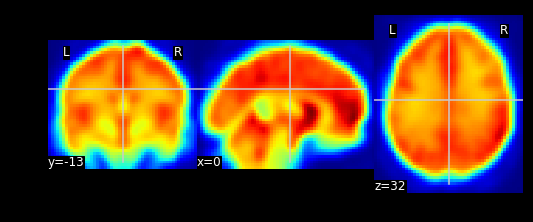

In [10]:
x_org = reconstruct_image_affine(x_true_org, x_true_img)
x_org_img = image.index_img(x_org,0)
org_image = plotting.plot_epi(x_org_img, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

In [11]:
tsc_score_history = []
x_init_tcs = x_true_img * (1./norm_ground_x_init)
x_reconstr_init = reconstruct(x_init_tcs,ground_truth, ten_ones, mask_indices)
tsc_score_init = tsc(x_reconstr_init,ground_truth, ten_ones, mask_indices).astype('float32')
print (tsc_score_init)

0.9996317


In [12]:
norm_sparse_observation = np.linalg.norm(sparse_observation)
print (norm_sparse_observation)

0.87885875


In [13]:
#save initial costs
train_cost_init = relative_error_omega(x_init_tcs, ground_truth, sparse_observation)
tcs_z_score = tu.tsc_z_score(x_init_tcs,ground_truth,ten_ones, mask_indices, z_scored_mask)
rse_cost = relative_error(x_init_tcs,ground_truth)
cost_init = compute_loss(x_init, mask_indices, sparse_observation)

In [14]:

cost_history.append(cost_init)

tsc_score_history.append(tsc_score_init)
train_cost_history.append(train_cost_init)
tcs_z_scored_history.append(tcs_z_score)
rse_cost_history.append(rse_cost)


In [15]:
ground_truth_tf = tfe.Variable(tl.tensor(ground_truth))
sparsity_mask_tf = tfe.Variable(tl.tensor(mask_indices))
sparse_observation_tf = tfe.Variable(tl.tensor(sparse_observation))
ten_ones_tf = tfe.Variable(tl.tensor(ten_ones))

In [16]:
X = tfe.Variable(tl.tensor(x_init))
X_old = tfe.Variable(tl.tensor(x_init))

In [17]:
tensor_factors = []
for i in range(len(X.get_shape()._dims)):
    item = tfe.Variable(create_factor((X.shape[i] , ranks[i])))
    print(item.shape)
    tensor_factors.append(item)

(53, 53)
(63, 63)
(46, 46)
(144, 144)


In [18]:
core  = tfe.Variable(tl.tensor(x_init))

In [19]:
x_miss = tl.tucker_to_tensor(core, tensor_factors)

In [20]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

In [21]:
penalty = 0.0001
num_epochs = 5

In [22]:
train_cost = train_cost_init
i = 0

In [23]:
for i in range(num_epochs):
#while train_cost > epsilon:
    
    i = i + 1
    with tfe.GradientTape() as tape:
        rec = tl.tucker_to_tensor(core, tensor_factors)
        grad = rec*sparsity_mask_tf - sparse_observation_tf
        grad_norm = tl.norm(grad, 2)
        loss_value = 0.5*frobenius_norm_tf_squared(grad)
        for f in tensor_factors: 
            loss_value = loss_value + penalty*frobenius_norm_tf_squared(f)
    
    cost_history.append(loss_value)
    
    grads = tape.gradient(loss_value, [core] + tensor_factors)
    optimizer.apply_gradients(zip(grads, [core] + tensor_factors),
                              global_step=tf.train.get_or_create_global_step())

    X = rec * (1 - sparsity_mask_tf) + X * sparsity_mask_tf
    train_cost = frobenius_norm_tf(rec*sparsity_mask_tf - sparse_observation_tf)/norm_sparse_observation
    rse_cost = frobenius_norm_tf(rec - ground_truth)/frobenius_norm_tf(ground_truth)
    tsc_score = tsc(np.array(rec.numpy()),ground_truth, ten_ones, mask_indices)
    tcs_z_score = tu.tsc_z_score(np.array(rec.numpy()),ground_truth,ten_ones, mask_indices, z_scored_mask)
    
    tsc_score_history.append(tsc_score)
    train_cost_history.append(train_cost)
    tcs_z_scored_history.append(tcs_z_score)
    rse_cost_history.append(rse_cost)
    
    if i > 1:
        diff_train = np.abs(train_cost_history[i] - train_cost_history[i - 1]) / np.abs(train_cost_history[i])
        print("Epoch {:03d}: GradNorm: {:.10f}; Diff Train:{:.10f} ; Loss:{:.10f}; Train Cost: {:.10f}; TCS Score {:.10f}; TCS Z Score {:.10f}; RSE Cost: {:.10f}".format(i, grad_norm, diff_train, loss_value, train_cost, tsc_score, tcs_z_score, rse_cost))
        
        if diff_train <= train_epsilon:
            print("Optimization Completed. Breaking after " + str(i) + " iterations" + "; Reason Relative Tolerance of Training Iterations Exceeded Treheshold: " + str(train_epsilon))
            break
    
    else:
        print("Epoch {:03d}: GradNorm: {:.10f}; Loss:{:.10f}; Train Cost: {:.10f}; TCS Score {:.10f}; TCS Z Score {:.10f}; RSE Cost: {:.10f}".format(i, grad_norm, loss_value, train_cost, tsc_score, tcs_z_score, rse_cost))

    print("Current Iteration #:" + str(i))

Epoch 001: GradNorm: 0.8791204691; Loss:0.3868263364; Train Cost: 1.0002977848; TCS Score 0.9999998406; TCS Z Score 1.0000037352; RSE Cost: 0.9999997616
Current Iteration #:1
Epoch 002: GradNorm: 0.8790460229; Diff Train:0.0000846206 ; Loss:0.3867168725; Train Cost: 1.0002131462; TCS Score 1.0000125654; TCS Z Score 0.9999689154; RSE Cost: 0.9999372959
Current Iteration #:2
Epoch 003: GradNorm: 0.8787224293; Diff Train:0.0003682946 ; Loss:0.3864107132; Train Cost: 0.9998449087; TCS Score 0.9997472009; TCS Z Score 0.9995658979; RSE Cost: 0.9995917678
Current Iteration #:3
Epoch 004: GradNorm: 0.8772186637; Diff Train:0.0017142696 ; Loss:0.3850874603; Train Cost: 0.9981338382; TCS Score 0.9982176527; TCS Z Score 0.9975430102; RSE Cost: 0.9979229569
Current Iteration #:4
Epoch 005: GradNorm: 0.8718110323; Diff Train:0.0062027280 ; Loss:0.3803648651; Train Cost: 0.9919808507; TCS Score 0.9925337170; TCS Z Score 0.9904876534; RSE Cost: 0.9918783903
Current Iteration #:5
Epoch 006: GradNorm: 

Epoch 042: GradNorm: 0.1957176775; Diff Train:0.0244059712 ; Loss:0.0195744447; Train Cost: 0.2226952612; TCS Score 0.1528989592; TCS Z Score 0.3068608603; RSE Cost: 0.2088202238
Current Iteration #:42
Epoch 043: GradNorm: 0.1900160760; Diff Train:0.0300058778 ; Loss:0.0184743870; Train Cost: 0.2162077576; TCS Score 0.1517754715; TCS Z Score 0.3136453025; RSE Cost: 0.2032973021
Current Iteration #:43
Epoch 044: GradNorm: 0.1864276081; Diff Train:0.0192485731 ; Loss:0.0177982785; Train Cost: 0.2121246606; TCS Score 0.1533979450; TCS Z Score 0.3239053778; RSE Cost: 0.2002306432
Current Iteration #:44
Epoch 045: GradNorm: 0.1839890033; Diff Train:0.0132541023 ; Loss:0.0173464548; Train Cost: 0.2093499154; TCS Score 0.1536253070; TCS Z Score 0.3275373892; RSE Cost: 0.1980030835
Current Iteration #:45
Epoch 046: GradNorm: 0.1806782633; Diff Train:0.0183239430 ; Loss:0.0167434216; Train Cost: 0.2055828273; TCS Score 0.1492959517; TCS Z Score 0.3203036133; RSE Cost: 0.1941650510
Current Itera

Epoch 083: GradNorm: 0.0870767683; Diff Train:0.0166435968 ; Loss:0.0042264597; Train Cost: 0.0990793705; TCS Score 0.0700897914; TCS Z Score 0.2221459842; RSE Cost: 0.0932542086
Current Iteration #:83
Epoch 084: GradNorm: 0.0855662450; Diff Train:0.0176533069 ; Loss:0.0040963637; Train Cost: 0.0973606333; TCS Score 0.0686835229; TCS Z Score 0.2183951845; RSE Cost: 0.0916041657
Current Iteration #:84
Epoch 085: GradNorm: 0.0841441303; Diff Train:0.0169009529 ; Loss:0.0039760307; Train Cost: 0.0957424939; TCS Score 0.0672539044; TCS Z Score 0.2137298770; RSE Cost: 0.0900326073
Current Iteration #:85
Epoch 086: GradNorm: 0.0828022212; Diff Train:0.0162062012 ; Loss:0.0038642418; Train Cost: 0.0942156166; TCS Score 0.0661533756; TCS Z Score 0.2104346799; RSE Cost: 0.0885918289
Current Iteration #:86
Epoch 087: GradNorm: 0.0814654753; Diff Train:0.0164087061 ; Loss:0.0037545136; Train Cost: 0.0926946178; TCS Score 0.0653802281; TCS Z Score 0.2092686961; RSE Cost: 0.0872117728
Current Itera

Epoch 124: GradNorm: 0.0502022579; Diff Train:0.0108155310 ; Loss:0.0017001567; Train Cost: 0.0571221001; TCS Score 0.0425480891; TCS Z Score 0.1366803387; RSE Cost: 0.0541383773
Current Iteration #:124
Epoch 125: GradNorm: 0.0496693291; Diff Train:0.0107295448 ; Loss:0.0016736184; Train Cost: 0.0565157123; TCS Score 0.0421199516; TCS Z Score 0.1348918363; RSE Cost: 0.0535678454
Current Iteration #:125
Epoch 126: GradNorm: 0.0491467714; Diff Train:0.0106325848 ; Loss:0.0016478548; Train Cost: 0.0559211262; TCS Score 0.0417291887; TCS Z Score 0.1333710035; RSE Cost: 0.0530136749
Current Iteration #:126
Epoch 127: GradNorm: 0.0486354455; Diff Train:0.0105134044 ; Loss:0.0016229178; Train Cost: 0.0553393215; TCS Score 0.0413347769; TCS Z Score 0.1318024289; RSE Cost: 0.0524692126
Current Iteration #:127
Epoch 128: GradNorm: 0.0481313057; Diff Train:0.0104742832 ; Loss:0.0015986081; Train Cost: 0.0547656901; TCS Score 0.0409099029; TCS Z Score 0.1300271534; RSE Cost: 0.0519259311
Current I

Epoch 165: GradNorm: 0.0346129984; Diff Train:0.0078568337 ; Loss:0.0010402697; Train Cost: 0.0393840298; TCS Score 0.0295185987; TCS Z Score 0.0846410945; RSE Cost: 0.0373596214
Current Iteration #:165
Epoch 166: GradNorm: 0.0343448669; Diff Train:0.0078070210 ; Loss:0.0010310120; Train Cost: 0.0390789397; TCS Score 0.0292927735; TCS Z Score 0.0837807351; RSE Cost: 0.0370707065
Current Iteration #:166
Epoch 167: GradNorm: 0.0340804122; Diff Train:0.0077597178 ; Loss:0.0010219511; Train Cost: 0.0387780331; TCS Score 0.0290685330; TCS Z Score 0.0829336203; RSE Cost: 0.0367855169
Current Iteration #:167
Epoch 168: GradNorm: 0.0338194668; Diff Train:0.0077159097 ; Loss:0.0010130811; Train Cost: 0.0384811163; TCS Score 0.0288417612; TCS Z Score 0.0820628613; RSE Cost: 0.0365030430
Current Iteration #:168
Epoch 169: GradNorm: 0.0335620493; Diff Train:0.0076698321 ; Loss:0.0010043967; Train Cost: 0.0381882191; TCS Score 0.0286164452; TCS Z Score 0.0811946931; RSE Cost: 0.0362241380
Current I

Epoch 206: GradNorm: 0.0260275602; Diff Train:0.0062220083 ; Loss:0.0007785524; Train Cost: 0.0296151806; TCS Score 0.0221654050; TCS Z Score 0.0589554821; RSE Cost: 0.0280872229
Current Iteration #:206
Epoch 207: GradNorm: 0.0258674938; Diff Train:0.0061879228 ; Loss:0.0007743427; Train Cost: 0.0294330511; TCS Score 0.0220297826; TCS Z Score 0.0585328012; RSE Cost: 0.0279146265
Current Iteration #:207
Epoch 208: GradNorm: 0.0257093068; Diff Train:0.0061528990 ; Loss:0.0007702057; Train Cost: 0.0292530600; TCS Score 0.0218963767; TCS Z Score 0.0581213265; RSE Cost: 0.0277441721
Current Iteration #:208
Epoch 209: GradNorm: 0.0255529843; Diff Train:0.0061176363 ; Loss:0.0007661406; Train Cost: 0.0290751886; TCS Score 0.0217642164; TCS Z Score 0.0577136615; RSE Cost: 0.0275756549
Current Iteration #:209
Epoch 210: GradNorm: 0.0253984462; Diff Train:0.0060845413 ; Loss:0.0007621449; Train Cost: 0.0288993493; TCS Score 0.0216330747; TCS Z Score 0.0573081727; RSE Cost: 0.0274089798
Current I

Epoch 247: GradNorm: 0.0207474325; Diff Train:0.0049627419 ; Loss:0.0006520642; Train Cost: 0.0236072429; TCS Score 0.0177221639; TCS Z Score 0.0458809738; RSE Cost: 0.0223987512
Current Iteration #:247
Epoch 248: GradNorm: 0.0206454974; Diff Train:0.0049373708 ; Loss:0.0006498654; Train Cost: 0.0234912578; TCS Score 0.0176367935; TCS Z Score 0.0456402433; RSE Cost: 0.0222890116
Current Iteration #:248
Epoch 249: GradNorm: 0.0205445867; Diff Train:0.0049118218 ; Loss:0.0006476973; Train Cost: 0.0233764369; TCS Score 0.0175521874; TCS Z Score 0.0454014726; RSE Cost: 0.0221803468
Current Iteration #:249
Epoch 250: GradNorm: 0.0204446819; Diff Train:0.0048865811 ; Loss:0.0006455593; Train Cost: 0.0232627615; TCS Score 0.0174684349; TCS Z Score 0.0451653688; RSE Cost: 0.0220727660
Current Iteration #:250
Epoch 251: GradNorm: 0.0203457717; Diff Train:0.0048614177 ; Loss:0.0006434508; Train Cost: 0.0231502187; TCS Score 0.0173855793; TCS Z Score 0.0449323405; RSE Cost: 0.0219662972
Current I

Epoch 288: GradNorm: 0.0172662269; Diff Train:0.0040979497 ; Loss:0.0005817447; Train Cost: 0.0196461920; TCS Score 0.0147944962; TCS Z Score 0.0377619299; RSE Cost: 0.0186488759
Current Iteration #:288
Epoch 289: GradNorm: 0.0171960555; Diff Train:0.0040806872 ; Loss:0.0005804230; Train Cost: 0.0195663478; TCS Score 0.0147350975; TCS Z Score 0.0375993355; RSE Cost: 0.0185732152
Current Iteration #:289
Epoch 290: GradNorm: 0.0171264391; Diff Train:0.0040648719 ; Loss:0.0005791154; Train Cost: 0.0194871351; TCS Score 0.0146761496; TCS Z Score 0.0374379521; RSE Cost: 0.0184981320
Current Iteration #:290
Epoch 291: GradNorm: 0.0170574132; Diff Train:0.0040466762 ; Loss:0.0005778222; Train Cost: 0.0194085948; TCS Score 0.0146176596; TCS Z Score 0.0372778980; RSE Cost: 0.0184236839
Current Iteration #:291
Epoch 292: GradNorm: 0.0169889126; Diff Train:0.0040320619 ; Loss:0.0005765421; Train Cost: 0.0193306524; TCS Score 0.0145596334; TCS Z Score 0.0371192288; RSE Cost: 0.0183498356
Current I

Epoch 329: GradNorm: 0.0147918630; Diff Train:0.0035073247 ; Loss:0.0005371336; Train Cost: 0.0168307628; TCS Score 0.0126865125; TCS Z Score 0.0320024828; RSE Cost: 0.0159784909
Current Iteration #:329
Epoch 330: GradNorm: 0.0147403143; Diff Train:0.0034971570 ; Loss:0.0005362441; Train Cost: 0.0167721082; TCS Score 0.0126423076; TCS Z Score 0.0318816277; RSE Cost: 0.0159228165
Current Iteration #:330
Epoch 331: GradNorm: 0.0146891307; Diff Train:0.0034843793 ; Loss:0.0005353625; Train Cost: 0.0167138707; TCS Score 0.0125983984; TCS Z Score 0.0317615746; RSE Cost: 0.0158675294
Current Iteration #:331
Epoch 332: GradNorm: 0.0146383159; Diff Train:0.0034714250 ; Loss:0.0005344885; Train Cost: 0.0166560505; TCS Score 0.0125547812; TCS Z Score 0.0316423141; RSE Cost: 0.0158126205
Current Iteration #:332
Epoch 333: GradNorm: 0.0145878335; Diff Train:0.0034605458 ; Loss:0.0005336217; Train Cost: 0.0165986102; TCS Score 0.0125114524; TCS Z Score 0.0315238182; RSE Cost: 0.0157580860
Current I

Epoch 370: GradNorm: 0.0129379025; Diff Train:0.0030618417 ; Loss:0.0005059472; Train Cost: 0.0147212539; TCS Score 0.0110893020; TCS Z Score 0.0276252459; RSE Cost: 0.0139745474
Current Iteration #:370
Epoch 371: GradNorm: 0.0128985448; Diff Train:0.0030513224 ; Loss:0.0005053001; Train Cost: 0.0146764712; TCS Score 0.0110552354; TCS Z Score 0.0275316157; RSE Cost: 0.0139319617
Current Iteration #:371
Epoch 372: GradNorm: 0.0128594069; Diff Train:0.0030435510 ; Loss:0.0005046572; Train Cost: 0.0146319382; TCS Score 0.0110213763; TCS Z Score 0.0274385574; RSE Cost: 0.0138896443
Current Iteration #:372
Epoch 373: GradNorm: 0.0128205409; Diff Train:0.0030315181 ; Loss:0.0005040190; Train Cost: 0.0145877153; TCS Score 0.0109877215; TCS Z Score 0.0273460617; RSE Cost: 0.0138475979
Current Iteration #:373
Epoch 374: GradNorm: 0.0127819013; Diff Train:0.0030230084 ; Loss:0.0005033851; Train Cost: 0.0145437494; TCS Score 0.0109542672; TCS Z Score 0.0272540981; RSE Cost: 0.0138058122
Current I

Epoch 411: GradNorm: 0.0115054362; Diff Train:0.0026886791 ; Loss:0.0004826086; Train Cost: 0.0130913369; TCS Score 0.0098458217; TCS Z Score 0.0242029329; RSE Cost: 0.0124244494
Current Iteration #:411
Epoch 412: GradNorm: 0.0114746904; Diff Train:0.0026794057 ; Loss:0.0004821098; Train Cost: 0.0130563537; TCS Score 0.0098190377; TCS Z Score 0.0241291486; RSE Cost: 0.0123911593
Current Iteration #:412
Epoch 413: GradNorm: 0.0114441076; Diff Train:0.0026724050 ; Loss:0.0004816138; Train Cost: 0.0130215548; TCS Score 0.0097924072; TCS Z Score 0.0240557878; RSE Cost: 0.0123580536
Current Iteration #:413
Epoch 414: GradNorm: 0.0114137046; Diff Train:0.0026636750 ; Loss:0.0004811207; Train Cost: 0.0129869618; TCS Score 0.0097659246; TCS Z Score 0.0239828154; RSE Cost: 0.0123251388
Current Iteration #:414
Epoch 415: GradNorm: 0.0113834841; Diff Train:0.0026547841 ; Loss:0.0004806305; Train Cost: 0.0129525755; TCS Score 0.0097395928; TCS Z Score 0.0239102737; RSE Cost: 0.0122924224
Current I

Epoch 452: GradNorm: 0.0103784092; Diff Train:0.0023608461 ; Loss:0.0004642250; Train Cost: 0.0118089616; TCS Score 0.0088617727; TCS Z Score 0.0214933704; RSE Cost: 0.0112038720
Current Iteration #:452
Epoch 453: GradNorm: 0.0103540309; Diff Train:0.0023544680 ; Loss:0.0004638228; Train Cost: 0.0117812231; TCS Score 0.0088404341; TCS Z Score 0.0214346894; RSE Cost: 0.0111774616
Current Iteration #:453
Epoch 454: GradNorm: 0.0103298072; Diff Train:0.0023450134 ; Loss:0.0004634227; Train Cost: 0.0117536606; TCS Score 0.0088192111; TCS Z Score 0.0213763372; RSE Cost: 0.0111512085
Current Iteration #:454
Epoch 455: GradNorm: 0.0103057027; Diff Train:0.0023389822 ; Loss:0.0004630244; Train Cost: 0.0117262332; TCS Score 0.0087981040; TCS Z Score 0.0213183129; RSE Cost: 0.0111250980
Current Iteration #:455
Epoch 456: GradNorm: 0.0102817379; Diff Train:0.0023308210 ; Loss:0.0004626280; Train Cost: 0.0116989650; TCS Score 0.0087771076; TCS Z Score 0.0212606086; RSE Cost: 0.0110991308
Current I

Epoch 493: GradNorm: 0.0094806394; Diff Train:0.0020700288 ; Loss:0.0004491345; Train Cost: 0.0107874442; TCS Score 0.0080736441; TCS Z Score 0.0193321230; RSE Cost: 0.0102307759
Current Iteration #:493
Epoch 494: GradNorm: 0.0094611030; Diff Train:0.0020649601 ; Loss:0.0004487980; Train Cost: 0.0107652145; TCS Score 0.0080564506; TCS Z Score 0.0192851455; RSE Cost: 0.0102096014
Current Iteration #:494
Epoch 495: GradNorm: 0.0094416849; Diff Train:0.0020566368 ; Loss:0.0004484629; Train Cost: 0.0107431198; TCS Score 0.0080393477; TCS Z Score 0.0192384414; RSE Cost: 0.0101885498
Current Iteration #:495
Epoch 496: GradNorm: 0.0094223665; Diff Train:0.0020502557 ; Loss:0.0004481291; Train Cost: 0.0107211387; TCS Score 0.0080223299; TCS Z Score 0.0191919702; RSE Cost: 0.0101676006
Current Iteration #:496
Epoch 497: GradNorm: 0.0094031328; Diff Train:0.0020454838 ; Loss:0.0004477964; Train Cost: 0.0106992535; TCS Score 0.0080053969; TCS Z Score 0.0191457266; RSE Cost: 0.0101467390
Current I

Epoch 534: GradNorm: 0.0087572308; Diff Train:0.0018171609 ; Loss:0.0004363105; Train Cost: 0.0099643208; TCS Score 0.0074349728; TCS Z Score 0.0175956604; RSE Cost: 0.0094461404
Current Iteration #:534
Epoch 535: GradNorm: 0.0087413946; Diff Train:0.0018115574 ; Loss:0.0004360199; Train Cost: 0.0099463025; TCS Score 0.0074209473; TCS Z Score 0.0175577821; RSE Cost: 0.0094289500
Current Iteration #:535
Epoch 536: GradNorm: 0.0087256357; Diff Train:0.0018061055 ; Loss:0.0004357303; Train Cost: 0.0099283708; TCS Score 0.0074069874; TCS Z Score 0.0175200615; RSE Cost: 0.0094118491
Current Iteration #:536
Epoch 537: GradNorm: 0.0087099560; Diff Train:0.0018001474 ; Loss:0.0004354416; Train Cost: 0.0099105304; TCS Score 0.0073930942; TCS Z Score 0.0174825440; RSE Cost: 0.0093948347
Current Iteration #:537
Epoch 538: GradNorm: 0.0086943526; Diff Train:0.0017947170 ; Loss:0.0004351538; Train Cost: 0.0098927757; TCS Score 0.0073792672; TCS Z Score 0.0174452092; RSE Cost: 0.0093779052
Current I

Epoch 575: GradNorm: 0.0081670638; Diff Train:0.0016002086 ; Loss:0.0004250942; Train Cost: 0.0092928056; TCS Score 0.0069105043; TCS Z Score 0.0161878851; RSE Cost: 0.0088053448
Current Iteration #:575
Epoch 576: GradNorm: 0.0081540523; Diff Train:0.0015956350 ; Loss:0.0004248368; Train Cost: 0.0092780013; TCS Score 0.0068988993; TCS Z Score 0.0161570025; RSE Cost: 0.0087912064
Current Iteration #:576
Epoch 577: GradNorm: 0.0081411041; Diff Train:0.0015905319 ; Loss:0.0004245800; Train Cost: 0.0092632677; TCS Score 0.0068873464; TCS Z Score 0.0161262567; RSE Cost: 0.0087771369
Current Iteration #:577
Epoch 578: GradNorm: 0.0081282100; Diff Train:0.0015863082 ; Loss:0.0004243239; Train Cost: 0.0092485966; TCS Score 0.0068758425; TCS Z Score 0.0160956577; RSE Cost: 0.0087631317
Current Iteration #:578
Epoch 579: GradNorm: 0.0081153810; Diff Train:0.0015808481 ; Loss:0.0004240685; Train Cost: 0.0092339991; TCS Score 0.0068643900; TCS Z Score 0.0160652050; RSE Cost: 0.0087491926
Current I

Epoch 616: GradNorm: 0.0076791644; Diff Train:0.0014165445 ; Loss:0.0004150546; Train Cost: 0.0087376544; TCS Score 0.0064735887; TCS Z Score 0.0150347058; RSE Cost: 0.0082750218
Current Iteration #:616
Epoch 617: GradNorm: 0.0076683401; Diff Train:0.0014114993 ; Loss:0.0004148219; Train Cost: 0.0087253386; TCS Score 0.0064638481; TCS Z Score 0.0150092512; RSE Cost: 0.0082632462
Current Iteration #:617
Epoch 618: GradNorm: 0.0076575540; Diff Train:0.0014085707 ; Loss:0.0004145895; Train Cost: 0.0087130656; TCS Score 0.0064541442; TCS Z Score 0.0149839068; RSE Cost: 0.0082515152
Current Iteration #:618
Epoch 619: GradNorm: 0.0076468247; Diff Train:0.0014030543 ; Loss:0.0004143578; Train Cost: 0.0087008579; TCS Score 0.0064444827; TCS Z Score 0.0149586969; RSE Cost: 0.0082398392
Current Iteration #:619
Epoch 620: GradNorm: 0.0076361299; Diff Train:0.0014006248 ; Loss:0.0004141265; Train Cost: 0.0086886883; TCS Score 0.0064348604; TCS Z Score 0.0149335947; RSE Cost: 0.0082282126
Current I

Epoch 657: GradNorm: 0.0072706067; Diff Train:0.0012605215 ; Loss:0.0004059074; Train Cost: 0.0082727820; TCS Score 0.0061044188; TCS Z Score 0.0140795073; RSE Cost: 0.0078303479
Current Iteration #:657
Epoch 658: GradNorm: 0.0072614830; Diff Train:0.0012564693 ; Loss:0.0004056937; Train Cost: 0.0082624005; TCS Score 0.0060961251; TCS Z Score 0.0140582802; RSE Cost: 0.0078204097
Current Iteration #:658
Epoch 659: GradNorm: 0.0072523924; Diff Train:0.0012534170 ; Loss:0.0004054804; Train Cost: 0.0082520572; TCS Score 0.0060878699; TCS Z Score 0.0140371752; RSE Cost: 0.0078105056
Current Iteration #:659
Epoch 660: GradNorm: 0.0072433408; Diff Train:0.0012496723 ; Loss:0.0004052676; Train Cost: 0.0082417578; TCS Score 0.0060796432; TCS Z Score 0.0140161527; RSE Cost: 0.0078006475
Current Iteration #:660
Epoch 661: GradNorm: 0.0072343280; Diff Train:0.0012457983 ; Loss:0.0004050551; Train Cost: 0.0082315030; TCS Score 0.0060714436; TCS Z Score 0.0139951820; RSE Cost: 0.0077908277
Current I

Epoch 698: GradNorm: 0.0069245100; Diff Train:0.0011265971 ; Loss:0.0003974618; Train Cost: 0.0078789797; TCS Score 0.0057884480; TCS Z Score 0.0132789752; RSE Cost: 0.0074530821
Current Iteration #:698
Epoch 699: GradNorm: 0.0069167316; Diff Train:0.0011245506 ; Loss:0.0003972634; Train Cost: 0.0078701293; TCS Score 0.0057813078; TCS Z Score 0.0132610780; RSE Cost: 0.0074446015
Current Iteration #:699
Epoch 700: GradNorm: 0.0069089914; Diff Train:0.0011203609 ; Loss:0.0003970653; Train Cost: 0.0078613218; TCS Score 0.0057741963; TCS Z Score 0.0132432704; RSE Cost: 0.0074361502
Current Iteration #:700
Epoch 701: GradNorm: 0.0069012670; Diff Train:0.0011192429 ; Loss:0.0003968675; Train Cost: 0.0078525329; TCS Score 0.0057671064; TCS Z Score 0.0132255115; RSE Cost: 0.0074277278
Current Iteration #:701
Epoch 702: GradNorm: 0.0068935868; Diff Train:0.0011140781 ; Loss:0.0003966701; Train Cost: 0.0078437943; TCS Score 0.0057600426; TCS Z Score 0.0132078273; RSE Cost: 0.0074193408
Current I

Epoch 739: GradNorm: 0.0066283466; Diff Train:0.0010115269 ; Loss:0.0003895860; Train Cost: 0.0075419932; TCS Score 0.0055150336; TCS Z Score 0.0125999536; RSE Cost: 0.0071297488
Current Iteration #:739
Epoch 740: GradNorm: 0.0066216574; Diff Train:0.0010102001 ; Loss:0.0003894001; Train Cost: 0.0075343819; TCS Score 0.0055088273; TCS Z Score 0.0125846973; RSE Cost: 0.0071224445
Current Iteration #:740
Epoch 741: GradNorm: 0.0066150003; Diff Train:0.0010063911 ; Loss:0.0003892146; Train Cost: 0.0075268070; TCS Score 0.0055026360; TCS Z Score 0.0125694669; RSE Cost: 0.0071151652
Current Iteration #:741
Epoch 742: GradNorm: 0.0066083656; Diff Train:0.0010039955 ; Loss:0.0003890293; Train Cost: 0.0075192577; TCS Score 0.0054964739; TCS Z Score 0.0125543256; RSE Cost: 0.0071079158
Current Iteration #:742
Epoch 743: GradNorm: 0.0066017518; Diff Train:0.0010017777 ; Loss:0.0003888443; Train Cost: 0.0075117326; TCS Score 0.0054903248; TCS Z Score 0.0125391923; RSE Cost: 0.0071006897
Current I

Epoch 780: GradNorm: 0.0063727670; Diff Train:0.0009114553 ; Loss:0.0003821858; Train Cost: 0.0072511844; TCS Score 0.0052763315; TCS Z Score 0.0120170543; RSE Cost: 0.0068502855
Current Iteration #:780
Epoch 781: GradNorm: 0.0063669747; Diff Train:0.0009097134 ; Loss:0.0003820106; Train Cost: 0.0072445939; TCS Score 0.0052708887; TCS Z Score 0.0120038645; RSE Cost: 0.0068439478
Current Iteration #:781
Epoch 782: GradNorm: 0.0063612042; Diff Train:0.0009071289 ; Loss:0.0003818356; Train Cost: 0.0072380281; TCS Score 0.0052654635; TCS Z Score 0.0119907281; RSE Cost: 0.0068376251
Current Iteration #:782
Epoch 783: GradNorm: 0.0063554514; Diff Train:0.0009051810 ; Loss:0.0003816609; Train Cost: 0.0072314823; TCS Score 0.0052600594; TCS Z Score 0.0119776570; RSE Cost: 0.0068313284
Current Iteration #:783
Epoch 784: GradNorm: 0.0063497280; Diff Train:0.0009013564 ; Loss:0.0003814865; Train Cost: 0.0072249700; TCS Score 0.0052546652; TCS Z Score 0.0119645776; RSE Cost: 0.0068250676
Current I

Epoch 821: GradNorm: 0.0061506354; Diff Train:0.0008239390 ; Loss:0.0003751914; Train Cost: 0.0069984347; TCS Score 0.0050664596; TCS Z Score 0.0115110075; RSE Cost: 0.0066069798
Current Iteration #:821
Epoch 822: GradNorm: 0.0061455844; Diff Train:0.0008218859 ; Loss:0.0003750255; Train Cost: 0.0069926875; TCS Score 0.0050616573; TCS Z Score 0.0114994793; RSE Cost: 0.0066014407
Current Iteration #:822
Epoch 823: GradNorm: 0.0061405571; Diff Train:0.0008186933 ; Loss:0.0003748596; Train Cost: 0.0069869673; TCS Score 0.0050568741; TCS Z Score 0.0114880249; RSE Cost: 0.0065959310
Current Iteration #:823
Epoch 824: GradNorm: 0.0061355382; Diff Train:0.0008180290 ; Loss:0.0003746941; Train Cost: 0.0069812564; TCS Score 0.0050521059; TCS Z Score 0.0114765924; RSE Cost: 0.0065904302
Current Iteration #:824
Epoch 825: GradNorm: 0.0061305356; Diff Train:0.0008160262 ; Loss:0.0003745287; Train Cost: 0.0069755642; TCS Score 0.0050473447; TCS Z Score 0.0114651451; RSE Cost: 0.0065849433
Current I

Epoch 862: GradNorm: 0.0059563918; Diff Train:0.0007463727 ; Loss:0.0003685491; Train Cost: 0.0067774164; TCS Score 0.0048809118; TCS Z Score 0.0110671576; RSE Cost: 0.0063938764
Current Iteration #:862
Epoch 863: GradNorm: 0.0059519629; Diff Train:0.0007441090 ; Loss:0.0003683910; Train Cost: 0.0067723771; TCS Score 0.0048766576; TCS Z Score 0.0110570084; RSE Cost: 0.0063890149
Current Iteration #:863
Epoch 864: GradNorm: 0.0059475531; Diff Train:0.0007414266 ; Loss:0.0003682332; Train Cost: 0.0067673596; TCS Score 0.0048724186; TCS Z Score 0.0110469002; RSE Cost: 0.0063841739
Current Iteration #:864
Epoch 865: GradNorm: 0.0059431549; Diff Train:0.0007400472 ; Loss:0.0003680756; Train Cost: 0.0067623551; TCS Score 0.0048681875; TCS Z Score 0.0110367918; RSE Cost: 0.0063793431
Current Iteration #:865
Epoch 866: GradNorm: 0.0059387628; Diff Train:0.0007395608 ; Loss:0.0003679182; Train Cost: 0.0067573576; TCS Score 0.0048639743; TCS Z Score 0.0110267683; RSE Cost: 0.0063745216
Current I

Epoch 903: GradNorm: 0.0057856240; Diff Train:0.0006714945 ; Loss:0.0003622154; Train Cost: 0.0065831104; TCS Score 0.0047162742; TCS Z Score 0.0106752428; RSE Cost: 0.0062062787
Current Iteration #:903
Epoch 904: GradNorm: 0.0057816845; Diff Train:0.0006813663 ; Loss:0.0003620644; Train Cost: 0.0065786280; TCS Score 0.0047122033; TCS Z Score 0.0106643521; RSE Cost: 0.0062019080
Current Iteration #:904
Epoch 905: GradNorm: 0.0057778358; Diff Train:0.0006661665 ; Loss:0.0003619136; Train Cost: 0.0065742484; TCS Score 0.0047087906; TCS Z Score 0.0106577351; RSE Cost: 0.0061977296
Current Iteration #:905
Epoch 906: GradNorm: 0.0057738954; Diff Train:0.0006824273 ; Loss:0.0003617631; Train Cost: 0.0065697650; TCS Score 0.0047045708; TCS Z Score 0.0106457635; RSE Cost: 0.0061933277
Current Iteration #:906
Epoch 907: GradNorm: 0.0057701068; Diff Train:0.0006566328 ; Loss:0.0003616126; Train Cost: 0.0065654540; TCS Score 0.0047014019; TCS Z Score 0.0106406491; RSE Cost: 0.0061892527
Current I

Epoch 944: GradNorm: 0.0632087141; Diff Train:0.4408290982 ; Loss:0.0023352108; Train Cost: 0.0719213560; TCS Score 0.0710726735; TCS Z Score 0.0570354063; RSE Cost: 0.0717142969
Current Iteration #:944
Epoch 945: GradNorm: 0.0524924472; Diff Train:0.2041487396 ; Loss:0.0017218308; Train Cost: 0.0597279668; TCS Score 0.0585806506; TCS Z Score 0.0444780804; RSE Cost: 0.0594561398
Current Iteration #:945
Epoch 946: GradNorm: 0.0316727124; Diff Train:0.6573398709 ; Loss:0.0008408756; Train Cost: 0.0360384546; TCS Score 0.0353543893; TCS Z Score 0.0300850241; RSE Cost: 0.0358764976
Current Iteration #:946
Epoch 947: GradNorm: 0.0068537365; Diff Train:3.6212327480 ; Loss:0.0003643671; Train Cost: 0.0077984505; TCS Score 0.0062816572; TCS Z Score 0.0095668727; RSE Cost: 0.0074785650
Current Iteration #:947
Epoch 948: GradNorm: 0.0342084840; Diff Train:0.7996480465 ; Loss:0.0009280888; Train Cost: 0.0389237553; TCS Score 0.0378116175; TCS Z Score 0.0298726366; RSE Cost: 0.0386649780
Current I

Epoch 985: GradNorm: 0.0079699680; Diff Train:0.2669635713 ; Loss:0.0003693984; Train Cost: 0.0090685431; TCS Score 0.0076281218; TCS Z Score 0.0083578330; RSE Cost: 0.0087596159
Current Iteration #:985
Epoch 986: GradNorm: 0.0085112900; Diff Train:0.0636003911 ; Loss:0.0003730255; Train Cost: 0.0096844798; TCS Score 0.0086689922; TCS Z Score 0.0135287571; RSE Cost: 0.0094608236
Current Iteration #:986
Epoch 987: GradNorm: 0.0064794780; Diff Train:0.3135764301 ; Loss:0.0003582647; Train Cost: 0.0073726047; TCS Score 0.0056928709; TCS Z Score 0.0085263315; RSE Cost: 0.0070240083
Current Iteration #:987
Epoch 988: GradNorm: 0.0055813962; Diff Train:0.1609062999 ; Loss:0.0003525821; Train Cost: 0.0063507319; TCS Score 0.0044823538; TCS Z Score 0.0092683375; RSE Cost: 0.0059756297
Current Iteration #:988
Epoch 989: GradNorm: 0.0071227388; Diff Train:0.2163974494 ; Loss:0.0003619300; Train Cost: 0.0081045320; TCS Score 0.0068794773; TCS Z Score 0.0122182697; RSE Cost: 0.0078407796
Current I

Epoch 1026: GradNorm: 0.0054317093; Diff Train:0.0092151836 ; Loss:0.0003473570; Train Cost: 0.0061804121; TCS Score 0.0043368437; TCS Z Score 0.0093033654; RSE Cost: 0.0058110529
Current Iteration #:1026
Epoch 1027: GradNorm: 0.0054002381; Diff Train:0.0058277734 ; Loss:0.0003470198; Train Cost: 0.0061446028; TCS Score 0.0043391841; TCS Z Score 0.0097172942; RSE Cost: 0.0057820622
Current Iteration #:1027
Epoch 1028: GradNorm: 0.0054031764; Diff Train:0.0005438317 ; Loss:0.0003469161; Train Cost: 0.0061479462; TCS Score 0.0043503954; TCS Z Score 0.0097629110; RSE Cost: 0.0057867155
Current Iteration #:1028
Epoch 1029: GradNorm: 0.0054195100; Diff Train:0.0030138511 ; Loss:0.0003469464; Train Cost: 0.0061665312; TCS Score 0.0043256255; TCS Z Score 0.0093145895; RSE Cost: 0.0057977503
Current Iteration #:1029
Epoch 1030: GradNorm: 0.0054367352; Diff Train:0.0031683266 ; Loss:0.0003468487; Train Cost: 0.0061861309; TCS Score 0.0044260111; TCS Z Score 0.0099433561; RSE Cost: 0.0058310181


Epoch 1066: GradNorm: 0.0052968939; Diff Train:0.0009383513 ; Loss:0.0003421019; Train Cost: 0.0060270140; TCS Score 0.0042205146; TCS Z Score 0.0093986971; RSE Cost: 0.0056653386
Current Iteration #:1066
Epoch 1067: GradNorm: 0.0052958890; Diff Train:0.0001897924 ; Loss:0.0003419748; Train Cost: 0.0060258703; TCS Score 0.0042300752; TCS Z Score 0.0094812607; RSE Cost: 0.0056660217
Current Iteration #:1067
Epoch 1068: GradNorm: 0.0052921046; Diff Train:0.0007150916 ; Loss:0.0003418489; Train Cost: 0.0060215644; TCS Score 0.0042208171; TCS Z Score 0.0094335890; RSE Cost: 0.0056609097
Current Iteration #:1068
Epoch 1069: GradNorm: 0.0052896305; Diff Train:0.0004676922 ; Loss:0.0003417260; Train Cost: 0.0060187494; TCS Score 0.0042172852; TCS Z Score 0.0094194596; RSE Cost: 0.0056579998
Current Iteration #:1069
Epoch 1070: GradNorm: 0.0052889427; Diff Train:0.0001300733 ; Loss:0.0003416048; Train Cost: 0.0060179667; TCS Score 0.0042237128; TCS Z Score 0.0094702830; RSE Cost: 0.0056584510


Epoch 1106: GradNorm: 0.0052064862; Diff Train:0.0004353874 ; Loss:0.0003372198; Train Cost: 0.0059241443; TCS Score 0.0041399529; TCS Z Score 0.0092686649; RSE Cost: 0.0055671940
Current Iteration #:1106
Epoch 1107: GradNorm: 0.0052042780; Diff Train:0.0004242483 ; Loss:0.0003370996; Train Cost: 0.0059216321; TCS Score 0.0041375595; TCS Z Score 0.0092618647; RSE Cost: 0.0055647218
Current Iteration #:1107
Epoch 1108: GradNorm: 0.0052023102; Diff Train:0.0003783100 ; Loss:0.0003369796; Train Cost: 0.0059193927; TCS Score 0.0041366180; TCS Z Score 0.0092651213; RSE Cost: 0.0055627250
Current Iteration #:1108
Epoch 1109: GradNorm: 0.0051999041; Diff Train:0.0004626977 ; Loss:0.0003368597; Train Cost: 0.0059166551; TCS Score 0.0041329294; TCS Z Score 0.0092492146; RSE Cost: 0.0055598505
Current Iteration #:1109
Epoch 1110: GradNorm: 0.0051980470; Diff Train:0.0003572839 ; Loss:0.0003367398; Train Cost: 0.0059145419; TCS Score 0.0041326725; TCS Z Score 0.0092573366; RSE Cost: 0.0055580707


Epoch 1146: GradNorm: 0.0051237228; Diff Train:0.0003754861 ; Loss:0.0003324769; Train Cost: 0.0058299731; TCS Score 0.0040603833; TCS Z Score 0.0090909279; RSE Cost: 0.0054763700
Current Iteration #:1146
Epoch 1147: GradNorm: 0.0051216828; Diff Train:0.0003983288 ; Loss:0.0003323599; Train Cost: 0.0058276518; TCS Score 0.0040581255; TCS Z Score 0.0090840788; RSE Cost: 0.0054740808
Current Iteration #:1147
Epoch 1148: GradNorm: 0.0051197661; Diff Train:0.0003743374 ; Loss:0.0003322430; Train Cost: 0.0058254711; TCS Score 0.0040565565; TCS Z Score 0.0090820985; RSE Cost: 0.0054720221
Current Iteration #:1148
Epoch 1149: GradNorm: 0.0051177409; Diff Train:0.0003957568 ; Loss:0.0003321262; Train Cost: 0.0058231666; TCS Score 0.0040543355; TCS Z Score 0.0090754735; RSE Cost: 0.0054697529
Current Iteration #:1149
Epoch 1150: GradNorm: 0.0051158224; Diff Train:0.0003750260 ; Loss:0.0003320094; Train Cost: 0.0058209836; TCS Score 0.0040527142; TCS Z Score 0.0090731054; RSE Cost: 0.0054676859


Epoch 1186: GradNorm: 0.0050475886; Diff Train:0.0004259049 ; Loss:0.0003278554; Train Cost: 0.0057433448; TCS Score 0.0039856305; TCS Z Score 0.0089105388; RSE Cost: 0.0053925617
Current Iteration #:1186
Epoch 1187: GradNorm: 0.0050461991; Diff Train:0.0002754181 ; Loss:0.0003277414; Train Cost: 0.0057417634; TCS Score 0.0039863222; TCS Z Score 0.0089240314; RSE Cost: 0.0053913798
Current Iteration #:1187
Epoch 1188: GradNorm: 0.0050438978; Diff Train:0.0004562376 ; Loss:0.0003276276; Train Cost: 0.0057391450; TCS Score 0.0039816006; TCS Z Score 0.0088981375; RSE Cost: 0.0053884350
Current Iteration #:1188
Epoch 1189: GradNorm: 0.0050427490; Diff Train:0.0002278055 ; Loss:0.0003275138; Train Cost: 0.0057378379; TCS Score 0.0039836117; TCS Z Score 0.0089209797; RSE Cost: 0.0053876950
Current Iteration #:1189
Epoch 1190: GradNorm: 0.0050402079; Diff Train:0.0005041531 ; Loss:0.0003274002; Train Cost: 0.0057349466; TCS Score 0.0039773111; TCS Z Score 0.0088832472; RSE Cost: 0.0053842566


In [24]:
print("Optimization Completed After Iterations #:" + str(i))

Optimization Completed After Iterations #:1193


In [25]:
# Compute final results after algoritm completion

In [26]:
x_hat = reconstruct(np.array(rec.numpy()), ground_truth, ten_ones, mask_indices)
x_hat_img = reconstruct_image_affine(ground_truth_img, x_hat)

In [27]:
tcs_z_score = tu.tsc_z_score(x_hat,ground_truth, ten_ones,mask_indices, z_scored_mask)
tsc_score = tsc(x_hat,ground_truth, ten_ones, mask_indices)
        
print("Observed Ratio: " + str(observed_ratio))
print("Final TCS Z-Score: " + str(tcs_z_score))
print("Final TCS Score: " + str(tsc_score))


Observed Ratio: 0.75
Final TCS Z-Score: 0.008927704355642684
Final TCS Score: 0.003980591628450435


In [28]:
output_cost = OrderedDict()
indices = []

cost_arr = []
tsc_arr = []
tsc_z_score_arr = []
        
rse_arr = []

counter = 0
for item in  cost_history:
    print(item)
    cost_arr.append(item)
    indices.append(counter)
    counter = counter + 1
    
    output_cost['k'] = indices
    output_cost['cost'] = cost_arr
    
    output_df = pd.DataFrame(output_cost, index=indices)
        
    fig_id = 'solution_cost' + '_' + suffix
    mrd.save_csv_by_path(output_df, results_folder, fig_id)  

tsc_score_output = OrderedDict()
tsc_score_indices = []

counter = 0
for item in tcs_cost_history:
    tsc_arr.append(item)
    tsc_score_indices.append(counter)
    counter = counter + 1

tsc_score_output['k'] = tsc_score_indices
tsc_score_output['tsc_cost'] = tsc_arr
    
output_tsc_df = pd.DataFrame(tsc_score_output, index=tsc_score_indices)
fig_id = 'tsc_cost' + '_' + suffix
mrd.save_csv_by_path(output_tsc_df, results_folder, fig_id) 
        
# output z-score
tsc_z_score_output = OrderedDict()
tsc_z_score_indices = []
        
counter = 0
for item in tcs_z_scored_history:
    tsc_z_score_arr.append(item)
    tsc_z_score_indices.append(counter)
    counter = counter + 1

tsc_z_score_output['k'] = tsc_z_score_indices
tsc_z_score_output['tsc_z_cost'] = tsc_z_score_arr
        
output_tsc_z_df = pd.DataFrame( tsc_z_score_output, index=tsc_z_score_indices)
fig_id = 'tsc_z_cost' + '_' + suffix
mrd.save_csv_by_path(output_tsc_z_df, results_folder, fig_id) 
        
# output rse history
        
rse_output = OrderedDict()
rse_indices = []
counter = 0
        
for item in rse_cost_history:
    rse_arr.append(item)
    rse_indices.append(counter)
    counter = counter + 1

rse_output['k'] = rse_indices
rse_output['rse_cost'] = rse_arr
        
output_rse_df = pd.DataFrame( rse_output, index=rse_indices)
fig_id = 'rse_cost' + '_' + suffix
mrd.save_csv_by_path(output_rse_df, results_folder, fig_id) 
        
# output train history
train_arr = []
train_output = OrderedDict()
train_indices = []
counter = 0
        
for item in train_cost_history:
    train_arr.append(item)
    train_indices.append(counter)
    counter = counter + 1

train_output['k'] = train_indices
train_output['train_cost'] = train_arr
        
output_train_df = pd.DataFrame(train_output, index=train_indices)
fig_id = 'train_cost' + '_' + suffix
mrd.save_csv_by_path(output_train_df, results_folder, fig_id) 

0.8358912563483484
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.38682634, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.38671687, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.3864107, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.38508746, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.38036487, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.3668621, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.33565986, shape=(), dtype=float32)
Saving dataset /home/ec2-user/a

tf.Tensor(0.0036549114, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0035600376, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0034648317, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0033758879, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.003289476, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0032044044, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.003125495, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0030485562, shape=(), dt

tf.Tensor(0.0011689583, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0011568373, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.001145002, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00113343, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0011221227, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0011110695, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0011002655, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0010897046, shape=(), dty

tf.Tensor(0.00064555934, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0006434508, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0006413712, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0006393198, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0006372964, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00063529966, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00063332956, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0006313862, shape=(

tf.Tensor(0.00053984765, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0005389352, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00053803023, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0005371336, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00053624413, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0005353625, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00053448847, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0005336217, shape=

tf.Tensor(0.00049380085, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0004932344, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00049267145, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00049211207, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00049155636, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0004910041, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0004904552, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00048990955, shape

tf.Tensor(0.00045543042, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0004550681, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0004547073, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00045434802, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00045399033, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00045363407, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00045327938, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00045292606, shap

tf.Tensor(0.00043176996, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0004314935, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0004312179, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00043094324, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00043066917, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0004303961, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0004301237, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00042985223, shape=

tf.Tensor(0.0004148219, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00041458948, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00041435784, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00041412652, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00041389582, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00041366566, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00041343592, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00041320673, sha

tf.Tensor(0.00040129793, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0004010927, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00040088798, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0004006836, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00040047965, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00040027592, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00040007266, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00039986966, shap

tf.Tensor(0.00038682745, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00038664576, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0003864643, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00038628312, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00038610213, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00038592145, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0003857411, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00038556088, shap

tf.Tensor(0.00037485964, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00037469406, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0003745287, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0003743635, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00037419857, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00037403379, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00037386923, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00037370482, shap

tf.Tensor(0.00036449917, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00036434573, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00036419247, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00036403938, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0003638865, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0003637337, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00036358112, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00036342873, shap

tf.Tensor(0.0015834823, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00088307506, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0003686321, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00060087023, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00092962827, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0008423402, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00040261223, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0004694043, shape=

tf.Tensor(0.0003482746, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0003477601, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0003475273, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00034763597, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00034765233, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.000347357, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00034701978, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00034691612, shape=(

tf.Tensor(0.0003391539, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00033903215, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00033891056, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00033878928, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00033866818, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00033854716, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0003384261, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00033830496, shap

tf.Tensor(0.00033142685, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00033131056, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00033119434, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0003310782, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00033096212, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0003308461, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.00033073014, shape=(), dtype=float32)
Saving dataset /home/ec2-user/analysis/results/tucker/mr/75/results/solution_cost_25.csv
tf.Tensor(0.0003306143, shape

In [33]:
save_solution_scans(suffix, mr_folder, x_hat_img, x_miss_img, ground_truth_img, title,tsc_score, tcs_z_score, observed_ratio, images_folder)

Missing Ratio: 0.25
x_hat_path: /home/ec2-user/analysis/results/tucker/mr/75/scans/x_hat_img_25
x_miss_path: /home/ec2-user/analysis/results/tucker/mr/75/scans/x_miss_img_25
x_true_path: /home/ec2-user/analysis/results/tucker/mr/75/scans/x_true_img_25


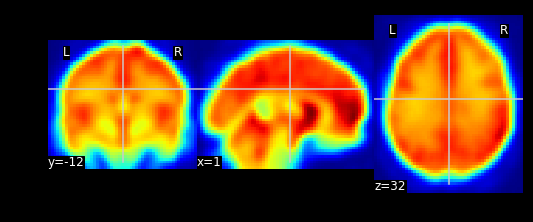

In [30]:
x_hat_img = reconstruct_image_affine(x_true_org, np.array(rec.numpy()))
x_hat_1 = image.index_img(x_hat_img,0)
#x_true_org_img = image.index_img(x_true_org,1)
x_hat_image = plotting.plot_epi(x_hat_1, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

In [ ]:
len(tcs_cost_history)

In [31]:
x_miss_numpy = np.array(x_miss.numpy())

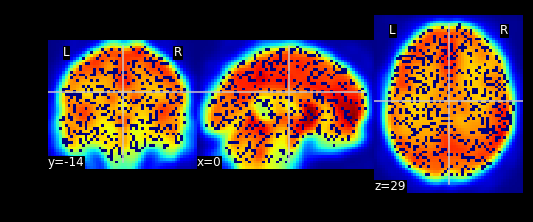

In [32]:
x_miss_img = reconstruct_image_affine(x_true_org, sparse_observation)
x_miss_1 = image.index_img(x_miss_img,0)
#x_true_org_img = image.index_img(x_true_org,1)
x_miss_img_image = plotting.plot_epi(x_miss_1, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)